# CNN and RNN

Convolutional and Recurrent Neural Networks for images and signals (feat. TensorFlow and PyTorch)

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import copy
from collections import defaultdict
from matplotlib import pyplot as plt
from tabulate import tabulate
from itertools import islice
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor, LGBMClassifier

import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision

In [2]:
# Limit TensorFlow GPU memory usage
gpu_devices = tf.config.list_physical_devices('GPU')
if len(gpu_devices) > 0:
    print(f'Detected GPU: {gpu_devices}')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

Detected GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Create TensorFlow Board (http://127.0.0.1:6006)
# %load_ext tensorboard
# %tensorboard --logdir logs/fit --port=6006

## MNIST Dataset

- http://yann.lecun.com/exdb/mnist/
- https://www.kaggle.com/c/digit-recognizer/discussion/61480

In [4]:
mnist_dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()

Test vs train lenght: 60000 vs 10000
Image size: (28, 28)
Image pixel range: 0 - 255
Classes: [0 1 2 3 4 5 6 7 8 9]


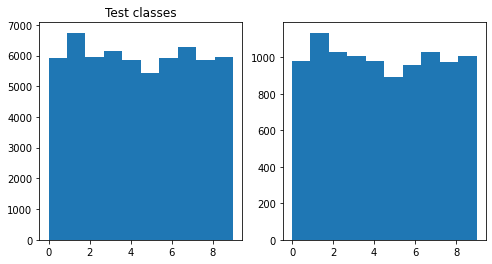

In [5]:
print(f'Test vs train lenght: {len(x_train)} vs {len(x_test)}')
print(f'Image size: {x_train[0].shape}')
print(f'Image pixel range: {x_train[0].min()} - {x_train[0].max()}')
print(f'Classes: {np.unique(y_train)}')
fix, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(y_train)
ax[0].set_title('Train classes')
ax[1].hist(y_test)
ax[0].set_title('Test classes')
_=_

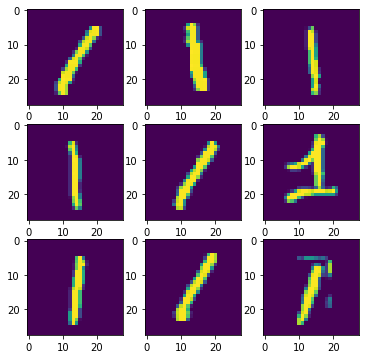

In [6]:
def show_mnist_digit(digit):
    count = 0
    i = 0
    fix, ax = plt.subplots(3, 3, figsize=(6, 6))
    while count < 3*3:
        if y_train[i] == digit:
            ax.ravel()[count].imshow(x_train[i])
            count += 1
        i += 1
        
show_mnist_digit(1)

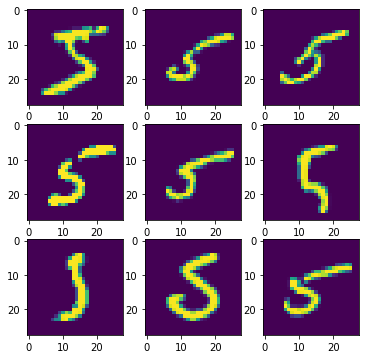

In [7]:
show_mnist_digit(5)

### TF2

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train[:, :, :, np.newaxis].astype('float32') / 255.0, y_train[:, np.newaxis]))
test_ds = tf.data.Dataset.from_tensor_slices((x_test[:, :, :, np.newaxis].astype('float32') / 255.0, y_test[:, np.newaxis]))

In [9]:
class KerasSequential(tf.keras.Sequential):
    def train_step(self, data):
        X, y = data
        with tf.GradientTape() as tape:
            y_pred = self(X, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        metric_dict = {m.name: m.result() for m in self.metrics}
        grad_norm = tf.linalg.global_norm(gradients)
        metric_dict.update({'grad_norm': grad_norm})
        return metric_dict

def train_eval_model(model, optimizer, loss, train_ds, test_ds, metrics=tuple(), grad_norm=True,
                     n_epoch=500, n_batch=128,
                     callbacks=None, board_prefix=None, device_name=None):
    with tf.device(device_name):
        k = int(len(train_ds)*0.8)
        train_ds_ = train_ds.take(k).batch(n_batch)
        val_ds_ = train_ds.skip(k).batch(n_batch)
        test_ds = test_ds.batch(n_batch)
        
        model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

        if board_prefix is not None:
            board_name = board_prefix + '_' + dt.datetime.now().strftime('%Y%m%dT%H%M%S')
            callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=Path('logs/tf2/') / board_name))
        train_history = model.fit(
            train_ds_,
            epochs=n_epoch, 
            validation_data=val_ds_,
            verbose=0,
            callbacks=callbacks,
        )

        _ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training loss', lw=1)
        for metric in metrics:
            _ = pd.DataFrame(train_history.history)[[metric, f'val_{metric}']].plot(title=f'Training {metric}', lw=1)
        if grad_norm:
            _ = pd.DataFrame(train_history.history)[['grad_norm']].plot(title=f'Training gradient norm', lw=1)

        train_results = model.evaluate(train_ds_)
        test_results = model.evaluate(test_ds)
        for i, metric in enumerate(metrics):
            print(f'Train {metric} {train_results[i+1]:.3f}')
            print(f'Test {metric} {test_results[i+1]:.3f}')
            
def get_lr_scheduler(decay_rate, first_epoch=0, last_epoch=1000):
    def sheduler_fun(epoch, lr):
        if (epoch > first_epoch) and (epoch < last_epoch):
            return lr * decay_rate
        else:
            return lr
    return sheduler_fun

#### Feedforward

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
79/79 [==============================] - 0s 1ms/step - loss: 0.0734 - accuracy: 0.9771
Train accuracy 0.998
Test accuracy 0.977
CPU times: user 4min 30s, sys: 1min 20s, total: 5min 50s
Wall time: 3min 44s


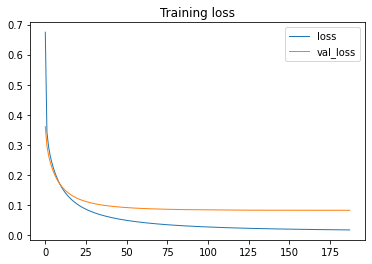

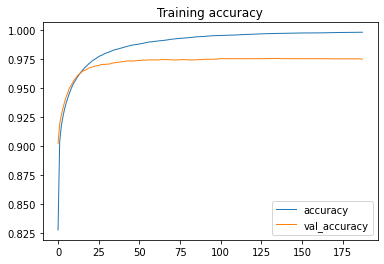

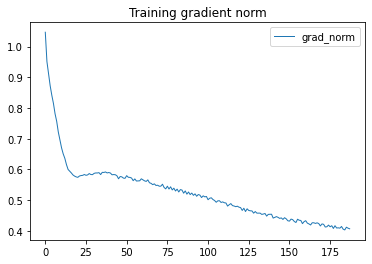

In [10]:
%%time
# Feedforward
model = KerasSequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'], 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_mlp',
)

#### CNN

79/79 [==============================] - 0s 2ms/step - loss: 0.0763 - accuracy: 0.9775
Train accuracy 0.993
Test accuracy 0.978
CPU times: user 2min 58s, sys: 46.5 s, total: 3min 45s
Wall time: 2min 27s


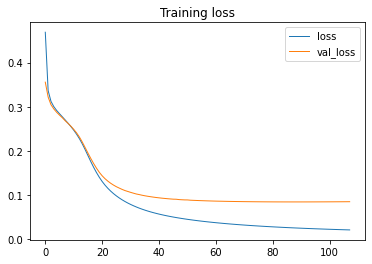

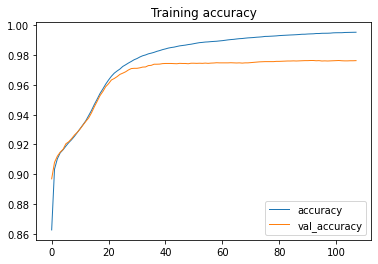

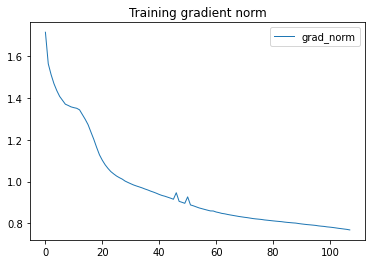

In [11]:
%%time
# CNN 1
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn1',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0609 - accuracy: 0.9812
Train accuracy 0.994
Test accuracy 0.981
CPU times: user 2min 26s, sys: 32.2 s, total: 2min 58s
Wall time: 2min 1s


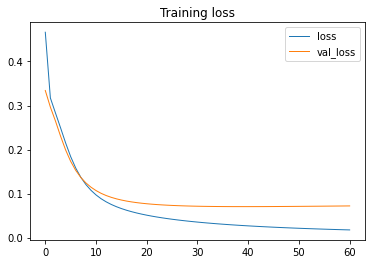

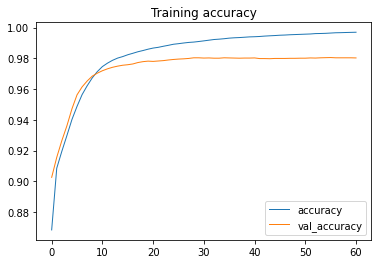

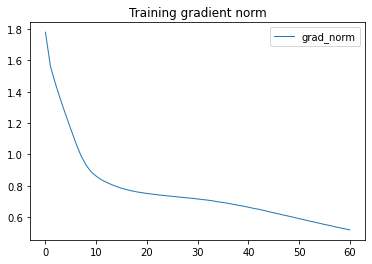

In [12]:
%%time
# CNN 2 (increase number of filters)
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn2',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9808
Train accuracy 0.990
Test accuracy 0.981
CPU times: user 1min 34s, sys: 24.6 s, total: 1min 59s
Wall time: 1min 17s


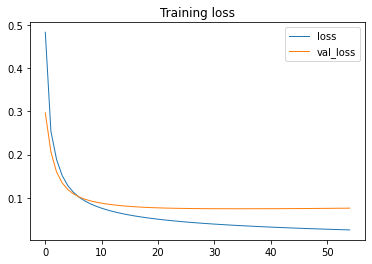

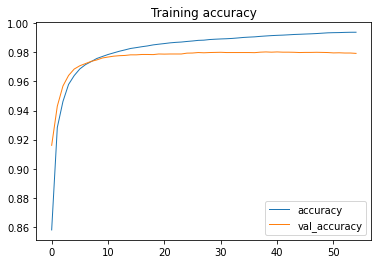

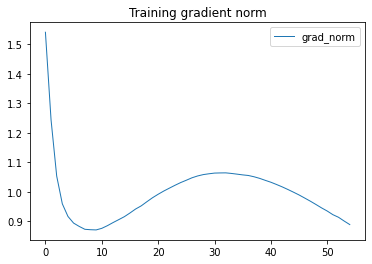

In [13]:
%%time
# CNN 3 (increase kernel size)
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=6, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn3',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0557 - accuracy: 0.9818
Train accuracy 0.994
Test accuracy 0.982
CPU times: user 4min 25s, sys: 59.9 s, total: 5min 25s
Wall time: 3min 38s


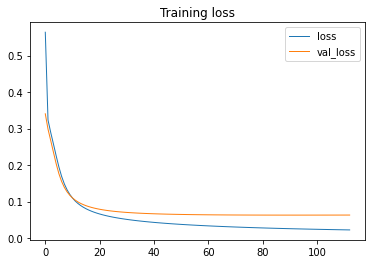

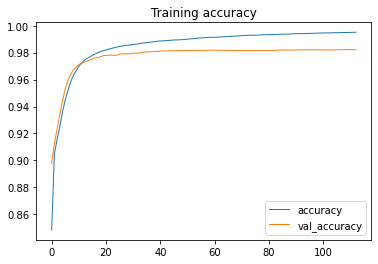

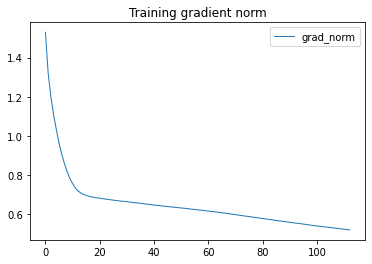

In [14]:
%%time
# CNN 4 (add a pooling layer)
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn4',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0603 - accuracy: 0.9824
Train accuracy 0.992
Test accuracy 0.982
CPU times: user 8min 46s, sys: 1min 49s, total: 10min 36s
Wall time: 7min 32s


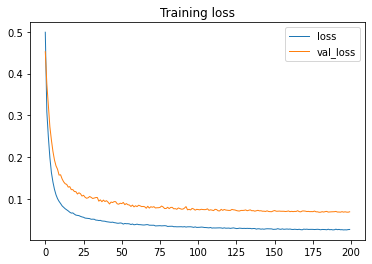

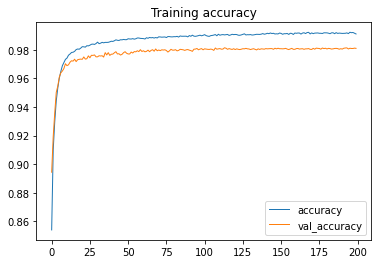

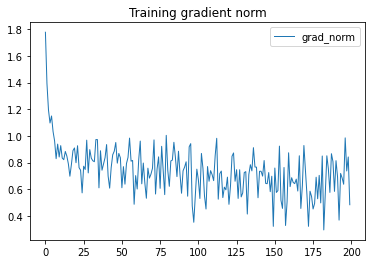

In [15]:
%%time
# CNN 5 (add a dropout layer)
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn5',
)

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
79/79 [==============================] - 0s 1ms/step - loss: 0.0788 - accuracy: 0.9775
Train accuracy 0.987
Test accuracy 0.978
CPU times: user 1min 26s, sys: 23.9 s, total: 1min 50s
Wall time: 1min 14s


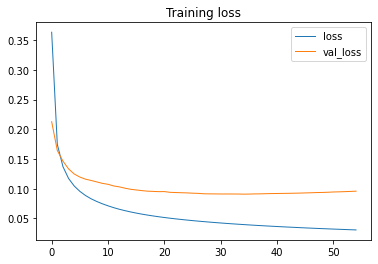

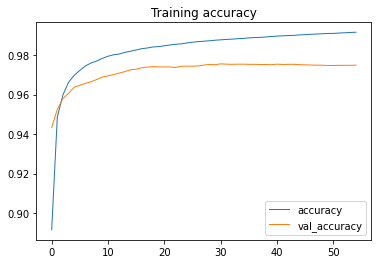

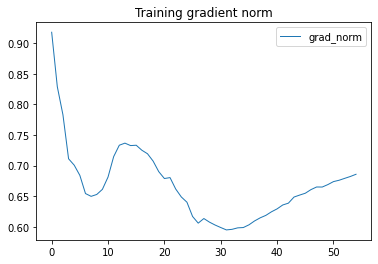

In [7]:
%%time
# CNN 6 (add a batch normalization layer)
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn6',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9933
Train accuracy 0.998
Test accuracy 0.993
CPU times: user 2min 55s, sys: 18.6 s, total: 3min 14s
Wall time: 2min 31s


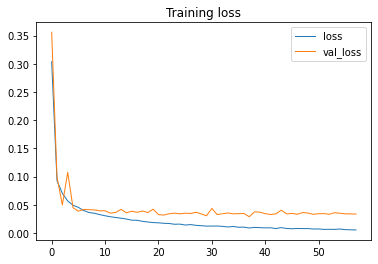

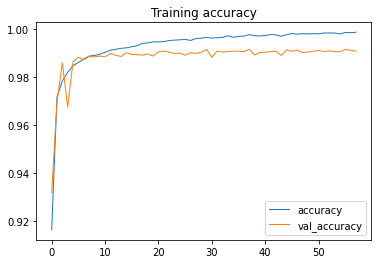

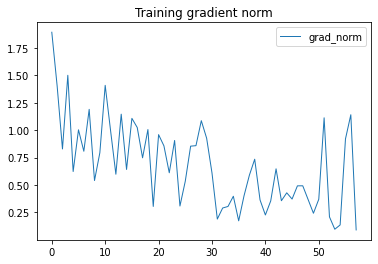

In [13]:
%%time
# CNN 7 (more layers)
model = KerasSequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05), # rotate between -2*pi*0.05..2*pi*0.05
    tf.keras.layers.ZeroPadding2D(2),  # 28 + 2*2 = 32
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn7',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9938
Train accuracy 0.998
Test accuracy 0.994
CPU times: user 2min 39s, sys: 19.2 s, total: 2min 59s
Wall time: 2min 5s


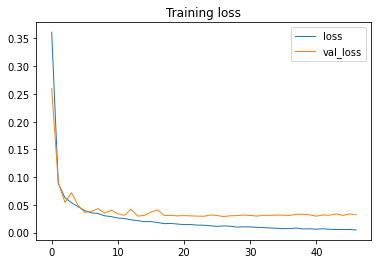

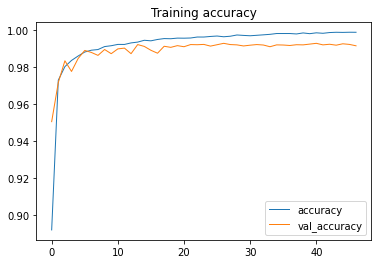

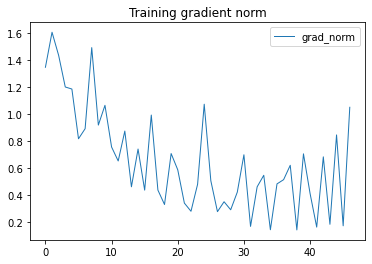

In [20]:
%%time
# CNN 8 (more layers, v.2)
model = KerasSequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05), # rotate between -2*pi*0.05..2*pi*0.05
    tf.keras.layers.ZeroPadding2D(2),  # 28 + 2*2 = 32
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, kernel_initializer=tf.keras.initializers.constant(0)),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn8',
)

#### CNN + Deconvolution (U-Net)
- https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py
- https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
- https://arxiv.org/abs/1505.04597

In [ ]:
%%time
# U-NET
# TODO: Finish
model = KerasSequential([
    # --- Preprocess
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05), # rotate between -2*pi*0.05..2*pi*0.05
    tf.keras.layers.ZeroPadding2D(2),  # 28 + 2*2 = 32
    # --- Downsample
    tf.keras.layers.Conv2D(filters=16, kernel_size=2, strides=1, padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    # --- Upsample
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=2, padding='same')
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=2, strides=2, padding='same')
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # --- Output
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=2, strides=2, padding='same')
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_unet',
)

## PyTorch

In [75]:
class PrepareData(Dataset):
    def __init__(self, X, y, transform=None, device=None):
        self.X = torch.from_numpy(X[:, np.newaxis, :, :]).float()
#         self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X, y = self.X[idx], self.y[idx]
        if self.transform is not None:
            X = self.transform(X)
        if self.device is not None:
            X, y = X.to(self.device), y.to(self.device)
        return X, y
    
    def to(self, device):
        self.device = device
#         self.X = self.X.to(device)
#         self.y = self.y.to(device)
    

ds_train = PrepareData(
    x_train / 255., y_train, 
    torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.RandomRotation(.05 * 360.),  # rotate between -2*pi*0.05..2*pi*0.05)
        torchvision.transforms.ToTensor(),
    ]),
)
ds_train = PrepareData(x_train / 255., y_train)
ds_test = PrepareData(x_test / 255., y_test)

In [73]:
class TorchLimitedScheduler:
    def __init__(self, scheduler, first_epoch=0, last_epoch=1000):
        self.scheduler = scheduler
        self.first_epoch = first_epoch
        self.last_epoch = last_epoch
        self.current_epoch = 0

    def step(self):
        if (self.current_epoch >= self.first_epoch) and (self.current_epoch < self.last_epoch):
            self.scheduler.step()
        self.current_epoch += 1

def eval_loss_nograd(model, loss_func, loader):
    with torch.no_grad():
        loss_c = 0
        for X_batch, y_batch in loader:
            loss = loss_func(model(X_batch), y_batch)
            loss_c += loss.item()
        return loss_c / len(loader) 
    
def torch_accuracy_score(predicted, labels):
    predicted = torch.argmax(predicted.data, 1)
    n_correct = (predicted == labels).sum() / float(len(predicted))
    return n_correct

def torch_mae(predicted, labels):
    return (predicted - labels).abs().sum() / float(len(predicted))

torch_metrics = {
    'accuracy': torch_accuracy_score,
    'mae': torch_mae,
}

def train_eval_model(model, optimizer, loss_func, train_ds, test_ds, scheduler=None, early_stopping=None,
                     device_name='auto', metrics=tuple(), board_prefix=None,
                     n_epoch=1000, n_batch=128):
    if device_name == 'auto':
        device_name = 'cuda' if torch.cuda.is_available() else 'gpu'
    device = torch.device(device_name)
    model.to(device)
    train_ds.to(device)
    test_ds.to(device)
    print(f'Running on {device_name}...')

    train_size = int(len(train_ds)*0.8)
    train_ds, val_ds = torch.utils.data.random_split(train_ds, [train_size, len(train_ds)-train_size])
    train_loader = DataLoader(train_ds, batch_size=n_batch, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=n_batch, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=n_batch, shuffle=True)
    
    if board_prefix is not None:
        board_name = board_prefix + '_' + dt.datetime.now().strftime('%Y%m%dT%H%M%S')
        writer = SummaryWriter(log_dir=Path('logs/torch/') / board_name)
    else:
        writer = None
 
    train_history = defaultdict(list)
    min_val_loss = None
    steps_without_improvement = 0
    for epoch in range(n_epoch):
        loss_c = 0
        grad_norm_c = 0
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_func(model(X_train_batch), y_train_batch)
            loss.backward()
            optimizer.step()
            loss_c += loss.item()
            for p in islice(model.parameters(), 5):
                grad_norm_c += float(torch.norm(p.grad))
        train_history['loss'].append(loss_c/len(train_loader))
        train_history['grad_norm'].append(grad_norm_c/len(train_loader))

        train_history['val_loss'].append(eval_loss_nograd(model, loss_func, val_loader))
        for metric in metrics:
            train_history[metric].append(eval_loss_nograd(model, torch_metrics[metric], train_loader))
            train_history[f'val_{metric}'].append(eval_loss_nograd(model, torch_metrics[metric], val_loader))
            
        if early_stopping is not None:
            if (min_val_loss is None) or (train_history['val_loss'][-1] < min_val_loss):
                min_val_loss = train_history['val_loss'][-1]
                best_state = copy.deepcopy(model.state_dict())
                steps_without_improvement = 0
            else:
                steps_without_improvement += 1
                if steps_without_improvement >= early_stopping:
                    model.load_state_dict(best_state)
                    break
        
        if writer is not None:
            for k, v in train_history.items():
                k_ = f'{k[4:]}/val' if k.startswith('val_') else f'{k}/train'
                writer.add_scalar(k_, v[-1], epoch)
                    
        if scheduler is not None:
            scheduler.step()

    _ = pd.DataFrame(train_history)[['loss', 'val_loss']].plot(title='Training loss', lw=1, alpha=0.8)

    for metric in metrics:
        _ = pd.DataFrame(train_history)[[metric, f'val_{metric}']].plot(title=f'Training {metric}', lw=1, alpha=0.8)
        train_metric = eval_loss_nograd(model, torch_metrics[metric], train_loader)
        test_metric = eval_loss_nograd(model, torch_metrics[metric], test_loader)
        print(f'Train {metric} {train_metric:.3f}')
        print(f'Test {metric}  {test_metric:.3f}')
    
    _ = pd.DataFrame(train_history)[['grad_norm']].plot(title='Training gradient norm', lw=1, alpha=0.8)

#### Feedforward

Running on cuda...
Train accuracy 0.997
Test accuracy  0.976
CPU times: user 4min 48s, sys: 1.61 s, total: 4min 50s
Wall time: 4min 20s


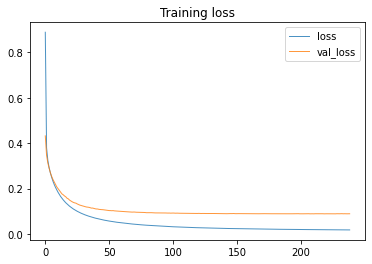

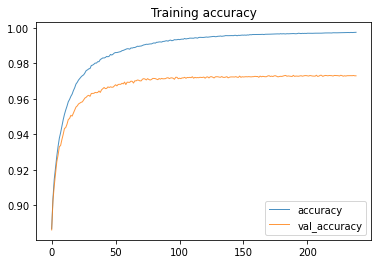

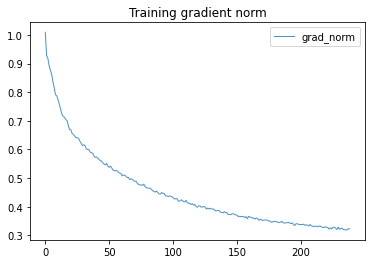

In [48]:
%%time
# Feedforward
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
scheduler = TorchLimitedScheduler(
    torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99),
    first_epoch=10, last_epoch=200,
)
loss_func = torch.nn.CrossEntropyLoss()
train_eval_model(
    model, optimizer, loss_func, ds_train, ds_test, scheduler=scheduler, early_stopping=20,
    metrics=['accuracy'],
    board_prefix='mnist_mlp',
)

#### CNN

Running on cuda...
Train accuracy 0.999
Test accuracy  0.992
CPU times: user 3min 31s, sys: 237 ms, total: 3min 32s
Wall time: 3min 28s


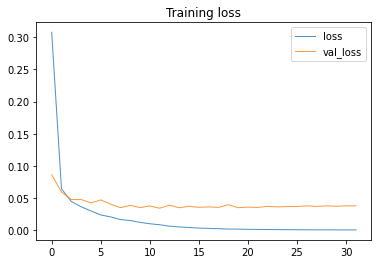

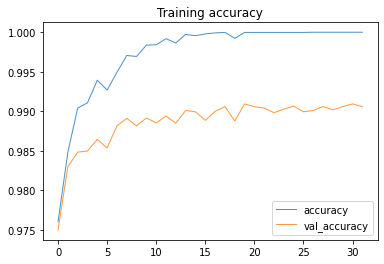

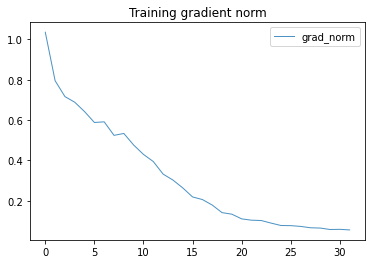

In [76]:
%%time
# CNN 7
model = torch.nn.Sequential(
#     torchvision.transforms.RandomRotation(.05 * 360.),  # moved to the dataset class
    torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=2),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=2),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=2),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Flatten(),
    torch.nn.Linear(288, 10),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
scheduler = TorchLimitedScheduler(
    torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99),
    first_epoch=10, last_epoch=200,
)
loss_func = torch.nn.CrossEntropyLoss()
train_eval_model(
    model, optimizer, loss_func, ds_train, ds_test, scheduler=scheduler, early_stopping=20,
    metrics=['accuracy'],
    board_prefix='mnist_cnn7',
)

## Correlated Time Series
- https://www.tensorflow.org/tutorials/structured_data/time_series
- https://www.tensorflow.org/guide/keras/rnn
- https://training.dewesoft.com/online/course/fft-spectral-analysis
- https://en.wikipedia.org/wiki/Fourier_transform

-0.008 0.337
-0.008 0.109
0.272 0.149


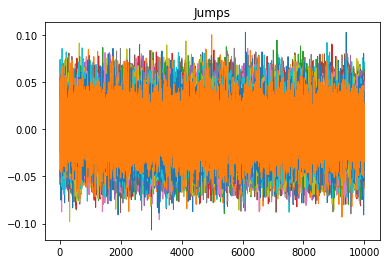

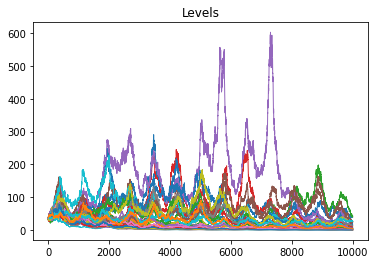

In [8]:
def corr(x, y):
    return np.corrcoef(x, y)[0, 1].round(3)

n = 10000
p = 32
stddev = 0.02
auto_corr = -0.3
cross_corr = 0.3
season_period = 24 * 30
season_impact = 0.002
# season_impact = 0.01
ext_impact = 0.01

jumps = np.random.normal(0, stddev, size=(n, p))
print(corr(jumps[:, 0], jumps[:, 1]), corr(jumps[0, :], jumps[1, :]))

jumps = jumps + auto_corr/(1-auto_corr)*np.roll(jumps, 1, axis=0)
print(corr(jumps[:, 0], jumps[:, 1]), corr(jumps[0, :], jumps[1, :]))

cross_corr_matrix = np.eye(p) + np.eye(p, k=-1) * cross_corr
jumps = jumps @ cross_corr_matrix
print(corr(jumps[:, 0], jumps[:, 1]), corr(jumps[0, :], jumps[1, :]))

seasons = np.sign(np.sin(2*np.pi*np.linspace(0, n // season_period, num=n)))
# seasons = (np.sin(2*np.pi*np.linspace(0, n // season_period, num=n)))
seasons = np.outer(seasons, np.random.uniform(0.6, 1.4, p))
jumps = jumps + season_impact * seasons

ext = np.random.laplace(0, 1., size=(n, p))
ext_conv = np.empty_like(ext)
for i in range(p):
    ext_conv[:, i] = np.convolve(ext[:, i], [0, 0, 0.7, 0.3], mode='same')
jumps = jumps + ext_impact * np.arctan(ext_conv * np.random.uniform(0.6, 1.4, p))

_ = pd.DataFrame(jumps).plot(lw=1, legend=False, title='Jumps')

levels = np.cumprod(jumps + 1, axis=0) * np.random.uniform(30, 40, size=p)
_ = pd.DataFrame(levels).plot(lw=1, legend=False, title='Levels')

-- Top frequencies --
      period_ratio  period_points  amplitude
12        0.071429     714.285714  10.172846
4888      0.000204       2.044990   8.246343
3585      0.000279       2.787845   7.754482
3780      0.000264       2.644104   7.070221
2568      0.000389       3.891051   6.832985


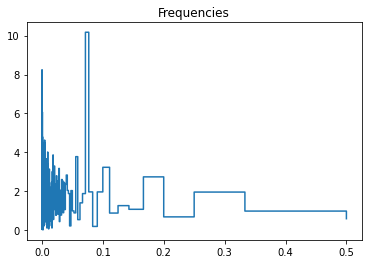

In [9]:
# fft = tf.signal.rfft(np.sin(2*np.pi*np.linspace(0, 20, 20*100)+0.6))
# fft = tf.signal.rfft((np.cumsum(seasons[:, 0])))
fft = tf.signal.rfft(((jumps[:, 0])))
fft = fft[1:]  # Discard the wave for frequency == 1
plt.step(1. / np.arange(2, len(fft)+2), np.abs(fft))  # The true frequency is 24*30 = 720
plt.title('Frequencies')

df = pd.DataFrame({
    'period_ratio': 1./np.arange(2, len(fft)+2),  # period = 1 / frequency
    'period_points': 1./np.arange(2, len(fft)+2)*len(fft)*2,  # RFFT only returns the first half of frequencies 
    'amplitude': np.abs(fft),
}).sort_values('amplitude', ascending=False)
print('-- Top frequencies --')
print(df.head(5))  

In [98]:
class KerasSequential(tf.keras.Sequential):
    def train_step(self, data):
        X, y = data
        with tf.GradientTape() as tape:
            y_pred = self(X, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        metric_dict = {m.name: m.result() for m in self.metrics}
        grad_norm = tf.linalg.global_norm(gradients)
        metric_dict.update({'grad_norm': grad_norm})
        return metric_dict

def train_eval_model(model, optimizer, loss, train_ds, val_ds, test_ds, metrics=tuple(), grad_norm=True,
                     n_epoch=500, n_batch=128,
                     callbacks=None, board_prefix=None, device_name=None,
                     history_skip_n_first=5):
    with tf.device(device_name):
        train_ds_ = train_ds.batch(n_batch)
        val_ds_ = val_ds.batch(n_batch)
        test_ds = test_ds.batch(n_batch)
        
        model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

        if board_prefix is not None:
            board_name = board_prefix + '_' + dt.datetime.now().strftime('%Y%m%dT%H%M%S')
            callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=Path('logs/tf2/') / board_name))
        train_history = model.fit(
            train_ds_,
            epochs=n_epoch, 
            validation_data=val_ds_,
            verbose=0,
            callbacks=callbacks,
        )

        _ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].iloc[history_skip_n_first:].plot(title='Training loss', lw=1)
        for metric in metrics:
            _ = pd.DataFrame(train_history.history)[[metric, f'val_{metric}']].iloc[history_skip_n_first:].plot(title=f'Training {metric}', lw=1)
        if grad_norm:
            _ = pd.DataFrame(train_history.history)[['grad_norm']].iloc[history_skip_n_first:].plot(title=f'Training gradient norm', lw=1)

        train_results = model.evaluate(train_ds_)
        test_results = model.evaluate(test_ds)
        for i, metric in enumerate(metrics):
            print(f'Train {metric} {train_results[i+1]:.4f}')
            print(f'Test  {metric} {test_results[i+1]:.4f}')
            
def get_lr_scheduler(decay_rate, first_epoch=0, last_epoch=1000):
    def sheduler_fun(epoch, lr):
        if (epoch > first_epoch) and (epoch < last_epoch):
            return lr * decay_rate
        else:
            return lr
    return sheduler_fun

def make_ts_datasets(labels, features, val_ratio, test_ratio, feature_window, label_window, label_offset, 
                     normalize=True, shuffle_train=True, shuffle_val=True, batch_size=128):
    assert feature_window >= 1
    assert label_offset >= 0
    assert label_window >= 1
    if features is not None:
        assert features.shape == labels.shape
        
    # Shape lables and features
    labels_ = labels[feature_window+label_offset:]
    if features is not None:
        features_ = np.stack([labels, features], axis=-1)[:-(label_window+label_offset)]
    else:
        features_ = labels[:-(label_window+label_offset)]
    n = len(labels_)
    
    # Normalize
    if normalize:
        features_mean = np.mean(features_[: int(n*(1-val_ratio-test_ratio))], axis=0)
        features_std = np.std(features_[: int(n*(1-val_ratio-test_ratio))], axis=0)
        features_ = (features_ - features_mean) / features_std
    
    # Create datasets
    # TODO: replace generators with TF native methods for scalability
    def train_gen():
        perm = np.random.permutation if shuffle_train else lambda x: x
        for i in perm(range(0, int(n*(1-val_ratio-test_ratio)))):
            yield features_[i:i+feature_window], labels_[i:i+label_window]
            
    def val_gen():
        perm = np.random.permutation if shuffle_val else lambda x: x
        for i in perm(range(int(n*(1-val_ratio-test_ratio)), int(n*(1-test_ratio)))):
            yield features_[i:i+feature_window], labels_[i:i+label_window]
            
    def test_gen():
        for i in range(int(n*(1-test_ratio)), n):
            yield features_[i:i+feature_window], labels_[i:i+label_window]
    
    output_dtypes = (tf.float32, tf.float32)
    output_shapes = features_[:feature_window].shape, labels_[:label_window].shape
    train_ds = tf.data.Dataset.from_generator(train_gen, output_dtypes, output_shapes)
    val_ds = tf.data.Dataset.from_generator(val_gen, output_dtypes, output_shapes)
    test_ds = tf.data.Dataset.from_generator(test_gen, output_dtypes, output_shapes)
    return train_ds, val_ds, test_ds

In [99]:
train_ds, val_ds, test_ds = make_ts_datasets(
    np.arange(0, 10), np.arange(0, -10, -1),  0.3, 0.3, 
    feature_window=2, label_window=1, label_offset=0, 
    normalize=False, shuffle_train=False, shuffle_val=False
)

for x, y in train_ds:
    print(x, y)
print()
for x, y in val_ds:
    print(x, y)
print()
for x, y in test_ds:
    print(x, y)

tf.Tensor(
[[ 0.  0.]
 [ 1. -1.]], shape=(2, 2), dtype=float32) tf.Tensor([2.], shape=(1,), dtype=float32)
tf.Tensor(
[[ 1. -1.]
 [ 2. -2.]], shape=(2, 2), dtype=float32) tf.Tensor([3.], shape=(1,), dtype=float32)
tf.Tensor(
[[ 2. -2.]
 [ 3. -3.]], shape=(2, 2), dtype=float32) tf.Tensor([4.], shape=(1,), dtype=float32)

tf.Tensor(
[[ 3. -3.]
 [ 4. -4.]], shape=(2, 2), dtype=float32) tf.Tensor([5.], shape=(1,), dtype=float32)
tf.Tensor(
[[ 4. -4.]
 [ 5. -5.]], shape=(2, 2), dtype=float32) tf.Tensor([6.], shape=(1,), dtype=float32)

tf.Tensor(
[[ 5. -5.]
 [ 6. -6.]], shape=(2, 2), dtype=float32) tf.Tensor([7.], shape=(1,), dtype=float32)
tf.Tensor(
[[ 6. -6.]
 [ 7. -7.]], shape=(2, 2), dtype=float32) tf.Tensor([8.], shape=(1,), dtype=float32)
tf.Tensor(
[[ 7. -7.]
 [ 8. -8.]], shape=(2, 2), dtype=float32) tf.Tensor([9.], shape=(1,), dtype=float32)


### Univariate

#### Baseline: last value

In [100]:
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.1, test_ratio=0.3, 
    feature_window=1, label_window=1, label_offset=0, 
    normalize=False,
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)

class Baseline(tf.keras.Model):
    def call(self, inputs):
        return inputs
    
baseline = Baseline()
baseline.compile(loss=tf.losses.MSE, metrics=['mae'])
baseline.evaluate(train_ds.batch(128))
baseline.evaluate(test_ds.batch(128))
_=_

(1,) (1,)
24/24 [==============================] - 0s 8ms/step - loss: 0.0012 - mae: 0.0274


#### TF2 Linear

(1,) (1,)
24/24 [==============================] - 0s 8ms/step - loss: 4.8983e-04 - mae: 0.0177
Train mae 0.0179
Test  mae 0.0177
CPU times: user 36.6 s, sys: 3.12 s, total: 39.7 s
Wall time: 25.6 s


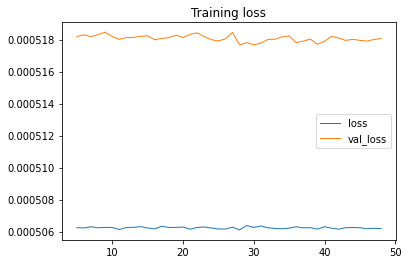

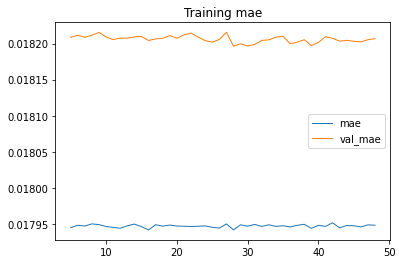

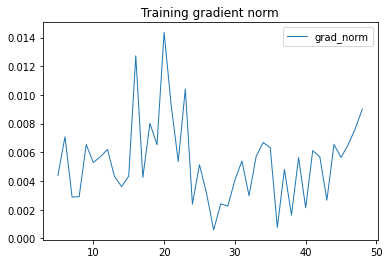

In [101]:
%%time
# Linear 1
# - output: univariate 
# - features: last jump value
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.1, test_ratio=0.3, 
    feature_window=1, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Dense(1),
])
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.5)

train_eval_model(
    model, optimizer, loss, train_ds=train_ds, val_ds=val_ds, test_ds=test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_linear1',
)

(720,) (1,)
22/22 [==============================] - 0s 8ms/step - loss: 5.5311e-04 - mae: 0.0188
Train mae 0.0169
Test  mae 0.0188
CPU times: user 1min 5s, sys: 5.81 s, total: 1min 10s
Wall time: 46.3 s


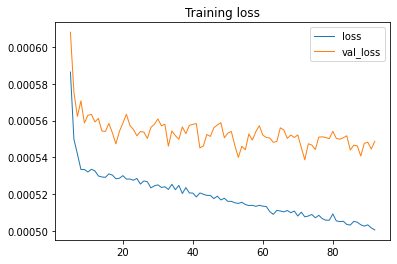

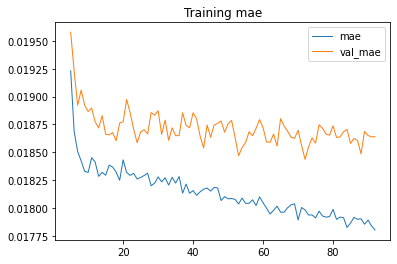

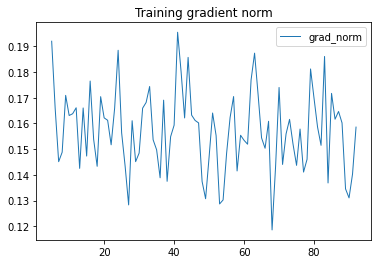

In [102]:
%%time
# Linear 2
# - output: univariate 
# - features: multiple jump values
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.1, test_ratio=0.3, 
    feature_window=24*30, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Dense(1),
])
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.5)

train_eval_model(
    model, optimizer, loss, train_ds=train_ds, val_ds=val_ds, test_ds=test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_linear2',
)

(720, 2) (1,)
22/22 [==============================] - 0s 8ms/step - loss: 6.0025e-04 - mae: 0.0197
Train mae 0.0149
Test  mae 0.0197
CPU times: user 59.7 s, sys: 5.22 s, total: 1min 4s
Wall time: 43.1 s


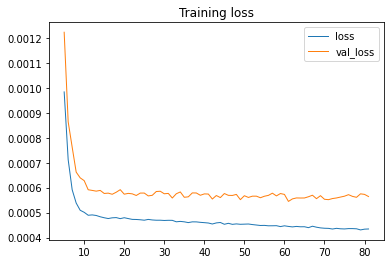

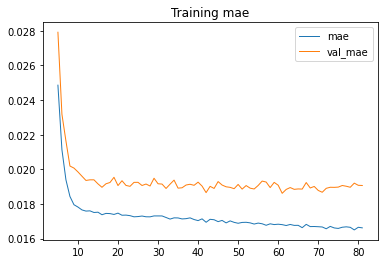

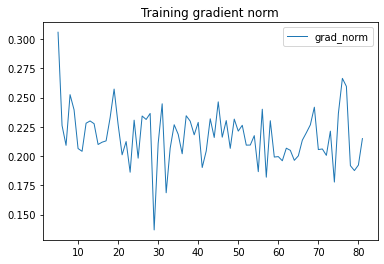

In [103]:
%%time
# Linear 3
# - output: univariate 
# - features: multiple jump and ext values
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], ext[:, 0], val_ratio=0.1, test_ratio=0.3, 
    feature_window=24*30, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.5)

train_eval_model(
    model, optimizer, loss, train_ds=train_ds, val_ds=val_ds, test_ds=test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_linear3',
)

#### TF2 Feedforward

24/24 [==============================] - 0s 7ms/step - loss: 4.8981e-04 - mae: 0.0177
Train mae 0.0180
Test  mae 0.0177
CPU times: user 55.9 s, sys: 5.13 s, total: 1min
Wall time: 39.5 s


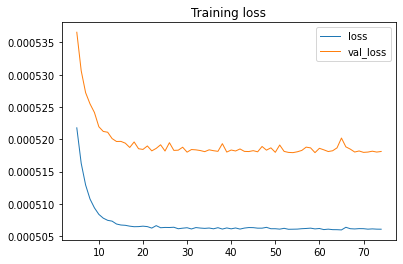

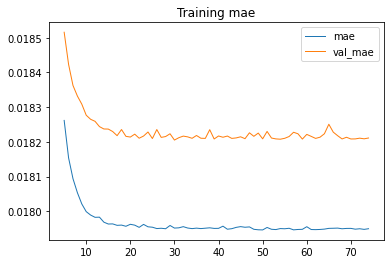

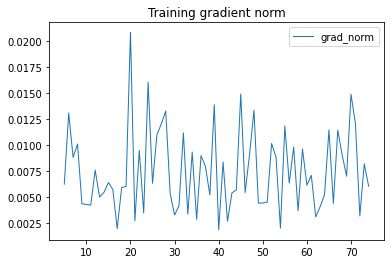

In [104]:
%%time
# Feedforward 1
# - output: univariate 
# - features: last jump value
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.1, test_ratio=0.3, 
    feature_window=1, label_window=1, label_offset=0, 
)
model = KerasSequential([
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1),
])
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.5)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_mlp1',
)

22/22 [==============================] - 0s 8ms/step - loss: 6.1146e-04 - mae: 0.0194
Train mae 0.0174
Test  mae 0.0194
CPU times: user 1min 10s, sys: 6.13 s, total: 1min 16s
Wall time: 50 s


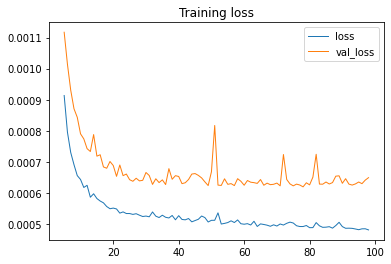

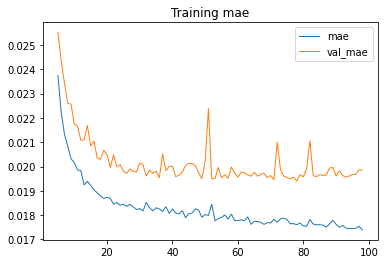

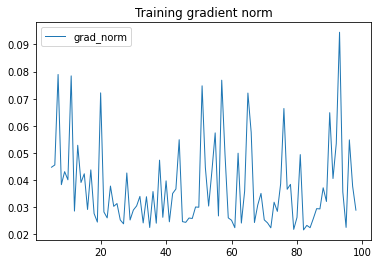

In [105]:
%%time
# Feedforward 2
# - output: univariate 
# - features: multiple jump values
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.1, test_ratio=0.3, 
    feature_window=24*30, label_window=1, label_offset=0, 
)
model = KerasSequential([
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1),
])
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.02, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_mlp2',
)

22/22 [==============================] - 0s 9ms/step - loss: 6.4922e-04 - mae: 0.0200
Train mae 0.0174
Test  mae 0.0200
CPU times: user 43 s, sys: 3.67 s, total: 46.7 s
Wall time: 30.9 s


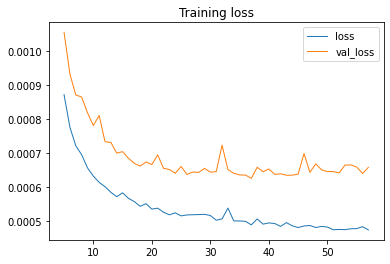

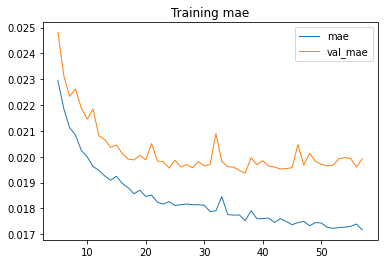

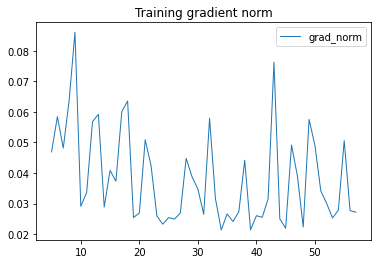

In [106]:
%%time
# Feedforward 3
# - output: univariate 
# - features: multiple jump and ext values (window=24*30)
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], ext[:, 0], val_ratio=0.1, test_ratio=0.3, 
    feature_window=24*30, label_window=1, label_offset=0, 
)
model = KerasSequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1),
])
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.02, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_mlp3',
)

16/16 [==============================] - 0s 8ms/step - loss: 5.4856e-04 - mae: 0.0188
Train mae 0.0157
Test  mae 0.0188
CPU times: user 2min 8s, sys: 11.5 s, total: 2min 19s
Wall time: 1min 30s


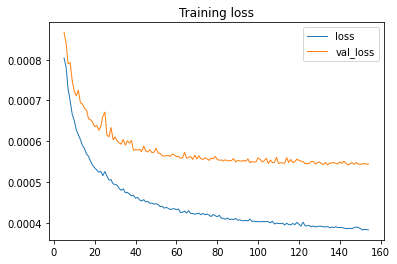

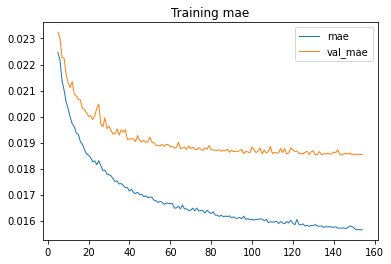

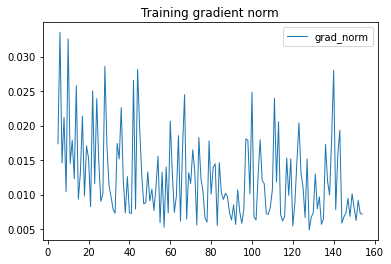

In [107]:
%%time
# Feedforward 4
# - output: univariate 
# - features: multiple jump and ext values (window=4)
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], ext[:, 0], val_ratio=0.2, test_ratio=0.2, 
    feature_window=4, label_window=1, label_offset=0, 
)
model = KerasSequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1),
])
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.05, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_mlp4',
)

#### TF2 CNN

In [119]:
# CNN models can work with input of varying length
model = KerasSequential([
    tf.keras.layers.Reshape((-1, 1)),
    tf.keras.layers.Conv1D(filters=4, kernel_size=(4,), strides=1, padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1),
])

print('--- Forecast 1 value ---')
x = tf.convert_to_tensor([1., 2., 3., 4.])
print(x.shape)
print(model(x[tf.newaxis, :]))

print('\n--- Forecast 3 values ---')
x = tf.convert_to_tensor([1., 2., 3., 4., 5., 6.])
print(x.shape)
print(model(x[tf.newaxis, :]))

--- Forecast 1 value ---
(4,)
tf.Tensor([[[0.]]], shape=(1, 1, 1), dtype=float32)

--- Forecast 3 values ---
(6,)
tf.Tensor(
[[[0.]
  [0.]
  [0.]]], shape=(1, 3, 1), dtype=float32)


(4,) (1,)
(None, 4) (None, 1, 1)
16/16 [==============================] - 0s 8ms/step - loss: 5.0601e-04 - mae: 0.0181
Train mae 0.0181
Test  mae 0.0181
CPU times: user 2min 57s, sys: 16.3 s, total: 3min 13s
Wall time: 2min 2s


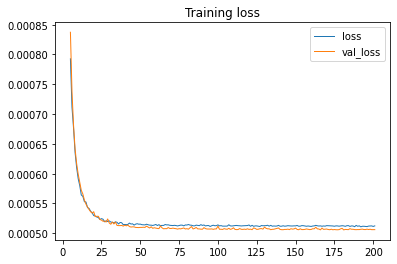

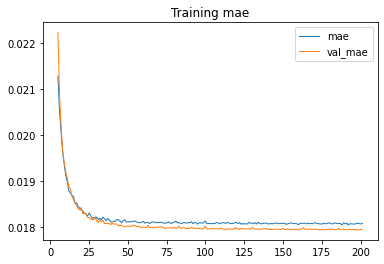

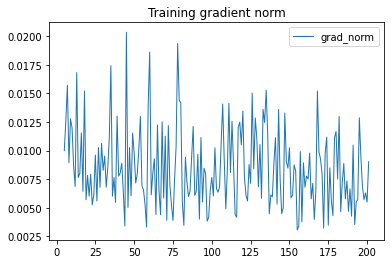

In [115]:
%%time
# CNN 1
# - output: univariate 
# - features: multiple jump values (window=4)
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=4, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Reshape((-1, 1), input_shape=(4,)),
    tf.keras.layers.Conv1D(filters=4, kernel_size=(4,), strides=1, padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_cnn1',
)

(720,) (1,)
(None, 720) (None, 1, 1)
15/15 [==============================] - 0s 8ms/step - loss: 5.1551e-04 - mae: 0.0182
Train mae 0.0182
Test  mae 0.0182
CPU times: user 41.5 s, sys: 3.73 s, total: 45.2 s
Wall time: 29 s


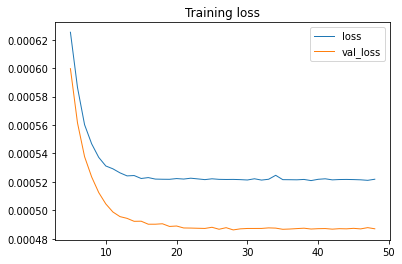

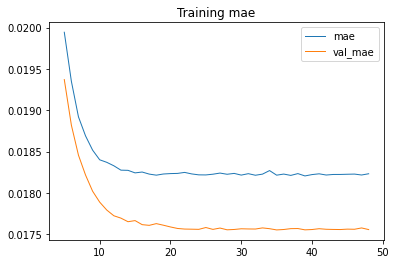

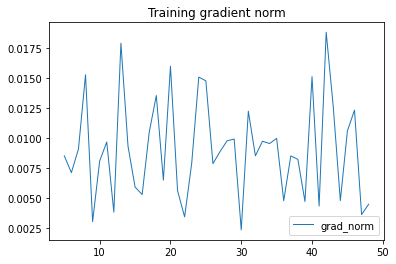

In [110]:
%%time
# CNN 2
# - output: univariate 
# - features: multiple jump values (window=30*24)
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=30*24, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Reshape((-1, 1), input_shape=(30*24,)),
    tf.keras.layers.Conv1D(filters=4, kernel_size=(30*24,), strides=1, padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_cnn2',
)

(720,) (1,)
(None, 720) (None, 1, 1)
15/15 [==============================] - 0s 9ms/step - loss: 5.1962e-04 - mae: 0.0183
Train mae 0.0182
Test  mae 0.0183
CPU times: user 54.8 s, sys: 4.29 s, total: 59.1 s
Wall time: 38.5 s


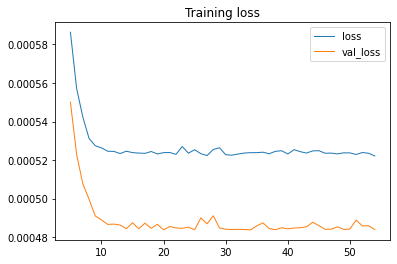

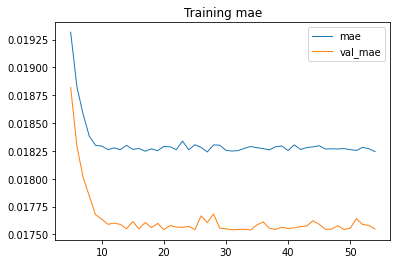

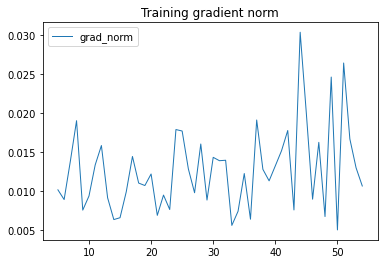

In [111]:
%%time
# CNN 3
# - output: univariate 
# - features: multiple jump values (deep, window=24*30)
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=24*30, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Reshape((-1, 1), input_shape=(24*30,)),
    tf.keras.layers.Conv1D(filters=4, kernel_size=(4,), strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool1D(pool_size=(4,)),
    tf.keras.layers.Conv1D(filters=8, kernel_size=(4,), strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool1D(pool_size=(4,)),
    tf.keras.layers.Conv1D(filters=8, kernel_size=(4,), strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool1D(pool_size=(4,)),
    tf.keras.layers.Conv1D(filters=8, kernel_size=(4,), strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool1D(pool_size=(6,)),
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_cnn3',
)

(720, 2) (1,)
(None, 720, 2) (None, 1, 1)
15/15 [==============================] - 0s 9ms/step - loss: 5.1906e-04 - mae: 0.0183
Train mae 0.0182
Test  mae 0.0183
CPU times: user 1min 16s, sys: 6.09 s, total: 1min 22s
Wall time: 55 s


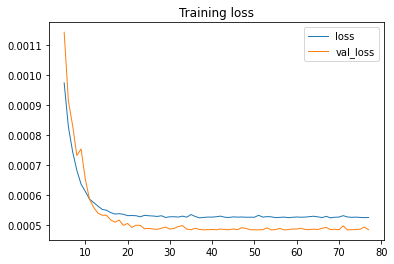

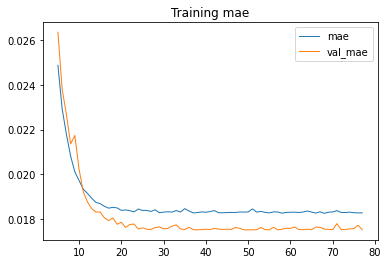

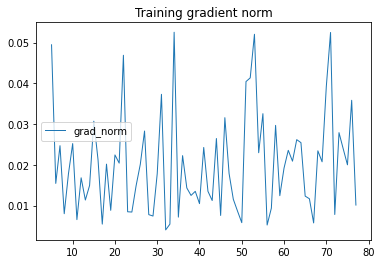

In [112]:
%%time
# CNN 4
# - output: univariate 
# - features: multiple jump and ext values
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], ext[:, 0], val_ratio=0.2, test_ratio=0.2, 
    feature_window=24*30, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Conv1D(filters=4, kernel_size=(4,), strides=1, padding='same', input_shape=(24*30, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool1D(pool_size=(4,)),
    tf.keras.layers.Conv1D(filters=8, kernel_size=(4,), strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool1D(pool_size=(4,)),
    tf.keras.layers.Conv1D(filters=8, kernel_size=(4,), strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool1D(pool_size=(4,)),
    tf.keras.layers.Conv1D(filters=8, kernel_size=(4,), strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool1D(pool_size=(6,)),
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_cnn4',
)

(720, 2) (1,)
(None, 720, 2) (None, 1, 1)
15/15 [==============================] - 0s 9ms/step - loss: 5.1910e-04 - mae: 0.0183
Train mae 0.0183
Test  mae 0.0183
CPU times: user 1min 51s, sys: 9.13 s, total: 2min
Wall time: 1min 19s


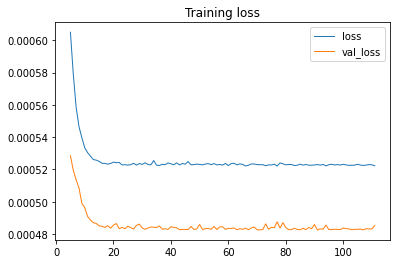

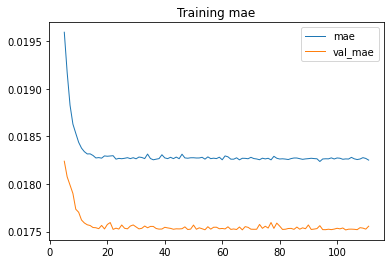

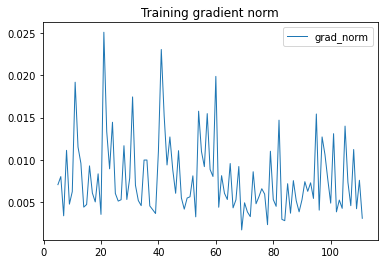

In [113]:
%%time
# CNN 5
# - output: univariate 
# - features: multiple jump and ext values (grouped separately)
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], ext[:, 0], val_ratio=0.2, test_ratio=0.2, 
    feature_window=24*30, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Conv1D(filters=4, kernel_size=(4,), strides=1, padding='same', groups=2, input_shape=(24*30, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool1D(pool_size=(4,)),
    tf.keras.layers.Conv1D(filters=8, kernel_size=(4,), strides=1, padding='same', groups=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool1D(pool_size=(4,)),
    tf.keras.layers.Conv1D(filters=8, kernel_size=(4,), strides=1, padding='same', groups=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool1D(pool_size=(4,)),
    tf.keras.layers.Conv1D(filters=8, kernel_size=(4,), strides=1, padding='same', groups=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool1D(pool_size=(6,)),
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_cnn5',
)

#### TF2 RNN

In [129]:
# RNN models can output one or all forecasted values at once
print('--- Output last forecasted value ---')
model = KerasSequential([
    tf.keras.layers.Reshape((-1, 1)),
    tf.keras.layers.SimpleRNN(1, return_sequences=False),
])
x = tf.convert_to_tensor([1., 2., 3., 4.])
print(x.shape)
print(model(x[tf.newaxis, :]))

print('\n--- Output all forecasted values ---')
model = KerasSequential([
    tf.keras.layers.Reshape((-1, 1)),
    tf.keras.layers.SimpleRNN(1, return_sequences=True),
])
x = tf.convert_to_tensor([1., 2., 3., 4.])
print(x.shape)
print(model(x[tf.newaxis, :]))

--- Output last forecasted value ---
(4,)
tf.Tensor([[0.45051232]], shape=(1, 1), dtype=float32)

--- Output all forecasted values ---
(4,)
tf.Tensor(
[[[0.42753032]
  [0.451204  ]
  [0.7256173 ]
  [0.8011681 ]]], shape=(1, 4, 1), dtype=float32)


In [132]:
# RNN models can work with input of varying length

# TODO: create an autoregressive model


(4,) (1,)
(None, 4) (None, 1)
16/16 [==============================] - 0s 8ms/step - loss: 4.9683e-04 - mae: 0.0179
Train mae 0.0180
Test  mae 0.0179
CPU times: user 25.3 s, sys: 2.34 s, total: 27.6 s
Wall time: 17.1 s


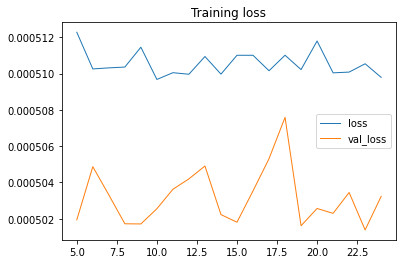

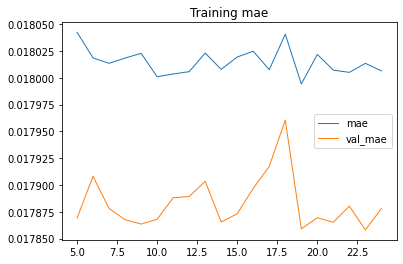

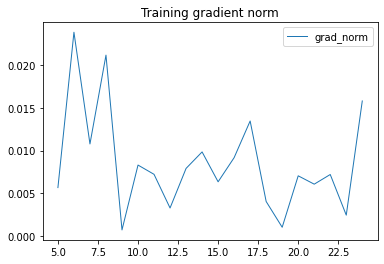

In [138]:
%%time
# RNN 1
# - output: univariate 
# - features: multiple jump values (window=4)
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=4, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Reshape((-1, 1), input_shape=(4,)),
    tf.keras.layers.SimpleRNN(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn1',
)

(720,) (1,)
15/15 [==============================] - 1s 34ms/step - loss: 5.0360e-04 - mae: 0.0180
Train mae 0.0180
Test  mae 0.0180
CPU times: user 8min 53s, sys: 38.1 s, total: 9min 31s
Wall time: 4min 27s


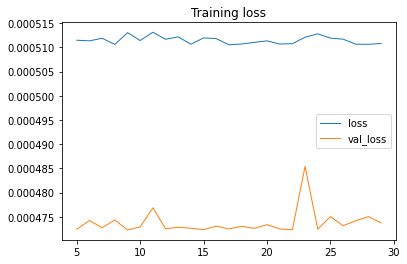

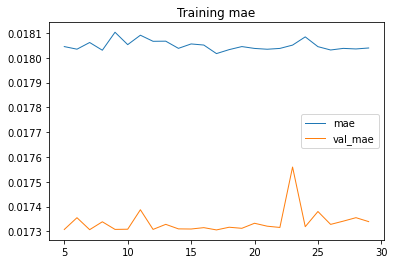

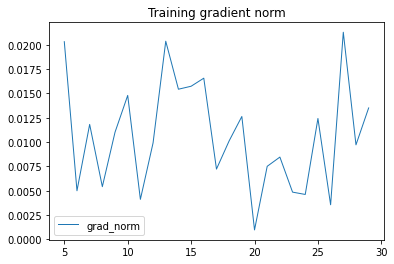

In [125]:
%%time
# RNN 2
# - output: univariate 
# - features: multiple jump values (window=30*24)
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=30*24, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Reshape((-1, 1), input_shape=(30*24,)),
    tf.keras.layers.SimpleRNN(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn2',
)

(720,) (1,)
15/15 [==============================] - 0s 16ms/step - loss: 5.0991e-04 - mae: 0.0181
Train mae 0.0181
Test  mae 0.0181
CPU times: user 1min 21s, sys: 4.53 s, total: 1min 26s
Wall time: 1min 7s


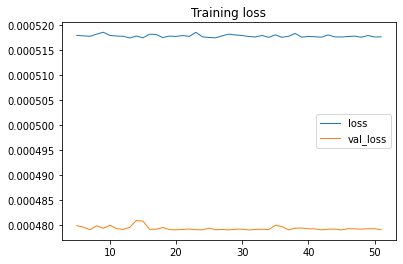

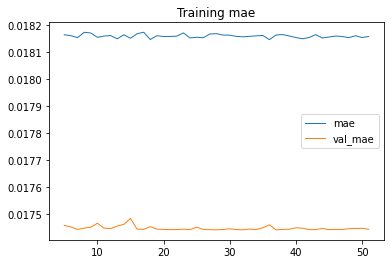

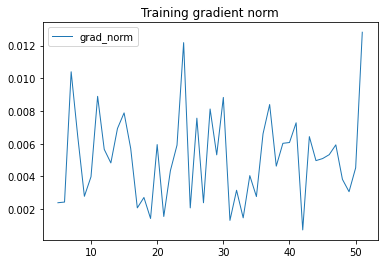

In [133]:
%%time
# RNN 3
# - output: univariate 
# - features: multiple jump values (window=30*24)
# - cell: LSTM
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=30*24, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Reshape((-1, 1), input_shape=(30*24,)),
    tf.keras.layers.LSTM(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn3',
)

(720,) (1,)
15/15 [==============================] - 0s 15ms/step - loss: 5.0935e-04 - mae: 0.0181
Train mae 0.0181
Test  mae 0.0181
CPU times: user 47.7 s, sys: 2.61 s, total: 50.3 s
Wall time: 39.3 s


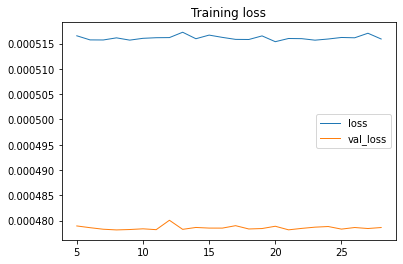

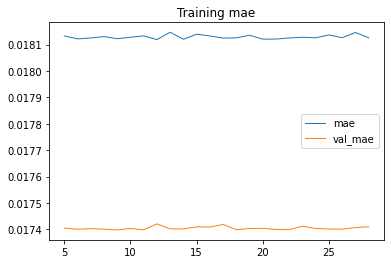

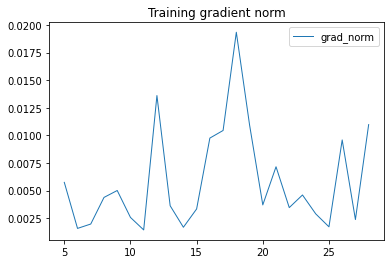

In [134]:
%%time
# RNN 4
# - output: univariate 
# - features: multiple jump values (window=30*24)
# - cell: GRU
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=30*24, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Reshape((-1, 1), input_shape=(30*24,)),
    tf.keras.layers.GRU(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn4',
)

(720,) (1,)
15/15 [==============================] - 0s 18ms/step - loss: 5.1356e-04 - mae: 0.0182
Train mae 0.0181
Test  mae 0.0182
CPU times: user 9min 3s, sys: 27.4 s, total: 9min 31s
Wall time: 7min 36s


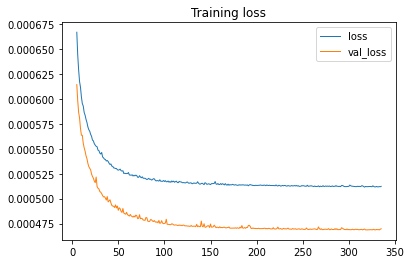

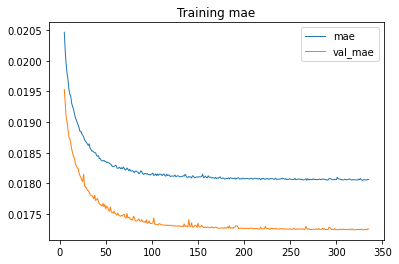

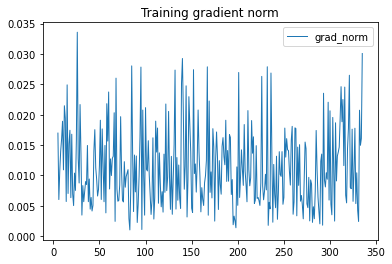

In [136]:
%%time
# RNN 5
# - output: univariate 
# - features: multiple jump values (window=30*24)
# - cell: GRU (16-unit state)
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=30*24, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Reshape((-1, 1), input_shape=(30*24,)),
    tf.keras.layers.GRU(16),
    tf.keras.layers.Dense(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn5',
)

(720, 2) (1,)
(None, 720, 2) (None, 1)
15/15 [==============================] - 0s 14ms/step - loss: 4.5754e-04 - mae: 0.0172
Train mae 0.0172
Test  mae 0.0172
CPU times: user 13min 18s, sys: 40.1 s, total: 13min 58s
Wall time: 11min 1s


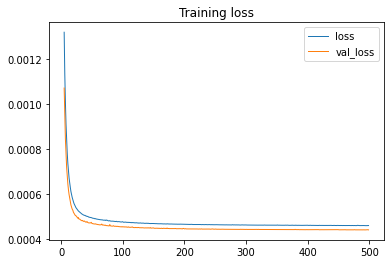

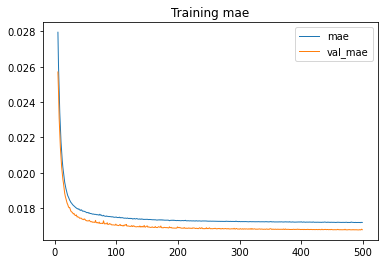

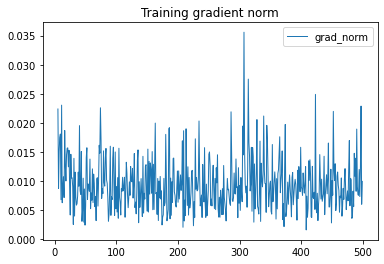

In [147]:
%%time
# RNN 6
# - output: univariate 
# - features: multiple jump and ext values (window=30*24)
# - cell: GRU (4 units)
# TODO: improve convergence
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], ext[:, 0], val_ratio=0.2, test_ratio=0.2, 
    feature_window=30*24, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
#     tf.keras.layers.Reshape((-1, 1), input_shape=(30*24,)),
    tf.keras.layers.GRU(4, input_shape=(30*24, 2)),
    tf.keras.layers.Dense(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.02, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn6',
)

(720, 2) (1,)
(None, 720, 2) (None, 1)
15/15 [==============================] - 0s 16ms/step - loss: 4.5552e-04 - mae: 0.0171
Train mae 0.0171
Test  mae 0.0171
CPU times: user 13min 27s, sys: 41 s, total: 14min 8s
Wall time: 11min 12s


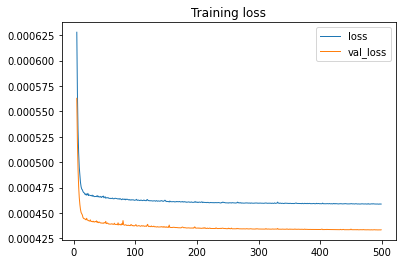

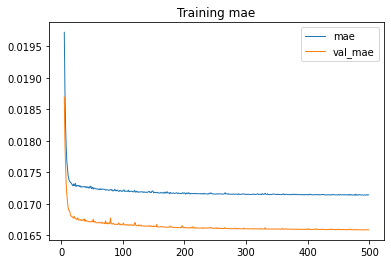

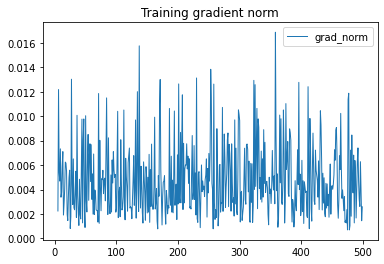

In [149]:
%%time
# RNN 7
# - output: univariate 
# - features: multiple jump and ext values (window=30*24)
# - cell: GRU (4 units) + LeakyReLU
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps[:, 0], ext[:, 0], val_ratio=0.2, test_ratio=0.2, 
    feature_window=30*24, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.GRU(4, input_shape=(30*24, 2)),
    tf.keras.layers.LeakyReLU(0.1),
    tf.keras.layers.Dense(1),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.02, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_uni_rnn7',
)

### Multivariate

#### Baseline: last value

In [114]:
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps, None, val_ratio=0.1, test_ratio=0.3, 
    feature_window=1, label_window=1, label_offset=0, 
    normalize=False,
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)

class Baseline(tf.keras.Model):
    def call(self, inputs):
        return inputs
    
baseline = Baseline()
baseline.compile(loss=tf.losses.MSE, metrics=['mae'])
baseline.evaluate(train_ds.batch(128))
baseline.evaluate(test_ds.batch(128))
_=_

(1, 32) (1, 32)
24/24 [==============================] - 0s 8ms/step - loss: 0.0012 - mae: 0.0273


#### TF2 CNN

(720, 32) (1, 32)
(None, 720, 32) (None, 1, 32)
15/15 [==============================] - 0s 25ms/step - loss: 5.0396e-04 - mae: 0.0179
Train mae 0.0179
Test  mae 0.0179
CPU times: user 6min 55s, sys: 19.3 s, total: 7min 14s
Wall time: 6min 37s


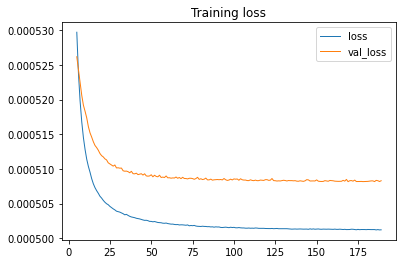

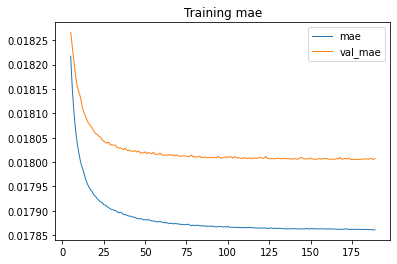

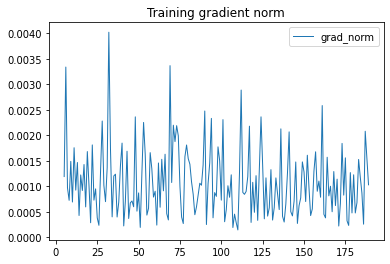

In [157]:
%%time
# CNN 1
# - output: multivariate 
# - features: multiple jump values
# TODO: find out why convergence is so slow
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps, None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=24*30, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.Reshape((24*30, 32, 1), input_shape=(24*30, 32)),
    tf.keras.layers.Conv2D(filters=4, kernel_size=(4, 2), strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(4, 1)),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 2), strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(4, 1)),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 2), strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
#     tf.keras.layers.MaxPool2D(pool_size=(4, 1)),
#     tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 2), strides=1, padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(4, 1)),
    tf.keras.layers.Conv2D(filters=1, kernel_size=(11, 1), strides=1, padding='valid'),
    tf.keras.layers.Reshape((1, 32,)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.02, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_multi_cnn1',
)

(720, 32, 2) (1, 32)
(None, 720, 32, 2) (None, 1, 32)
15/15 [==============================] - 0s 30ms/step - loss: 5.0205e-04 - mae: 0.0179
Train mae 0.0178
Test  mae 0.0179
CPU times: user 22min 35s, sys: 1min 10s, total: 23min 46s
Wall time: 21min 54s


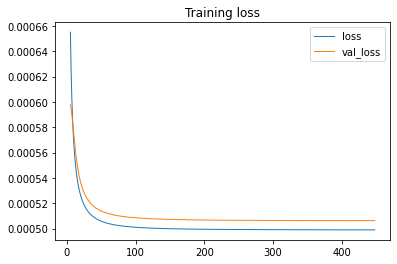

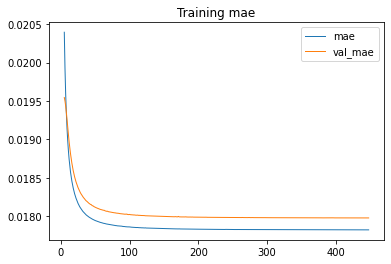

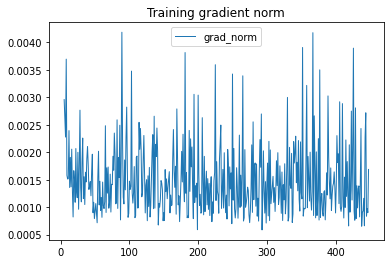

In [158]:
%%time
# CNN 2
# - output: multivariate 
# - features: multiple jump and ext values (grouped separately)
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps, ext, val_ratio=0.2, test_ratio=0.2, 
    feature_window=24*30, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
#     tf.keras.layers.Reshape((24*30*2, 32, 1), input_shape=(24*30*2, 32)),
    tf.keras.layers.Conv2D(filters=4, kernel_size=(4, 2), strides=1, groups=2, padding='same', input_shape=(24*30, 32, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(4, 1)),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 2), strides=1, groups=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(4, 1)),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 2), strides=1, groups=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
#     tf.keras.layers.MaxPool2D(pool_size=(4, 1)),
#     tf.keras.layers.Conv2D(filters=8, kernel_size=(4, 2), strides=1, groups=2, padding='same'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(4, 1)),
    tf.keras.layers.Conv2D(filters=1, kernel_size=(11, 1), strides=1, padding='valid'),
    tf.keras.layers.Reshape((1, 32,)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.02, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_multi_cnn2',
)

#### TF2 RNN

(720, 32) (1, 32)
(None, 720, 32) (None, 32)
15/15 [==============================] - 0s 20ms/step - loss: 8.8240e-04 - mae: 0.0236
Train mae 0.0232
Test  mae 0.0236
CPU times: user 17min 24s, sys: 45.3 s, total: 18min 9s
Wall time: 14min 47s


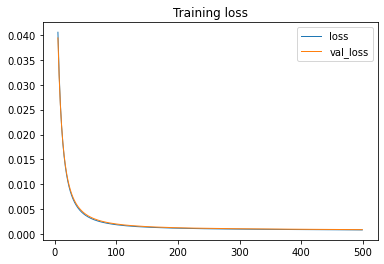

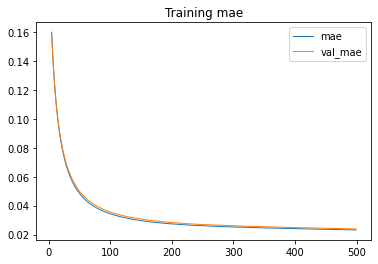

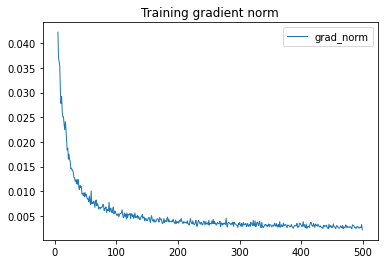

In [144]:
%%time
# RNN 5
# - output: univariate 
# - features: multiple jump values (window=30*24)
# - cell: GRU (16-unit state)
train_ds, val_ds, test_ds = make_ts_datasets(
    jumps, None, val_ratio=0.2, test_ratio=0.2, 
    feature_window=30*24, label_window=1, label_offset=0, 
)
for x, y in islice(train_ds, 1):
    print(x.shape, y.shape)
    
model = KerasSequential([
    tf.keras.layers.GRU(16, input_shape=(30*24, 32,)),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Reshape((1, -1,)),
])
print(model.input_shape, model.output_shape)
loss=tf.keras.losses.MSE
optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9)

train_eval_model(
    model, optimizer, loss, train_ds, val_ds, test_ds, metrics=['mae'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.995, 10., 300)),
    ],
    board_prefix='ts_multi_rnn1',
)